# Multi Armed Bandit

## O que é? 

Multi Armed Bandit (MaB) é uma técnica de aprendizado de máquina que visa maximizar os resultados baseado nas recompensas recebidas durante o experimento.

Para entender melhor o funcionamento do MaB, precisamos saber sua composição:
- **Agente**: O orquestrador das ações.
- **Estado:** São os resultados obtidos por cada banner no momento.
- **Ação:** É a escolha feita pelo Agente de acordo com o Estado do experimento, a tomada de decisão.
    - **Explore:** A ação de Explore tem o objetivo de conhecer melhor o ambiente ou identificar mudanças de comportamento dos usuários.<br>
    - **Exploit:** A ação de Exploit tem o objetivo de eplorar a ação que tem trazido o melhor retorno de acordo com o objetivo.
- **Estratégia:** É o racional de como o Agente vai definir qual é a melhor ação para o presente momento.
- **Recompensa:** Sempre que uma ação atinge algum objetivo, ela recebe alguma recompensa.

Basicamente o MaB vai atuar como um **gerenciador do tráfego do App ou Site**, guiando os usuários para os fluxos que vão te deixar mais próxmo do objetivo definido, **equilibrando ações de Explore e Exploit** aprendidos ao longo do processo do experimento.<br>

O fluxo funcionaria dessa maneira:<br> 

Após a chegada de um novo usuário no App, o **Agente** irá analisar o **Estado** do experimento e, de acordo com a **Estratégia** definida, irá realizar a **Ação** para direcioná-lo ao banner mais indicado, podendo gerar alguma recompensa ou não.<br>
As primeiras iterações vão ser sempre de **Explore**, já que não há conhecimento prévio de qual banner tem a melhor performance de acordo com o objetivo definido. Então o **Agente** irá escolher o banner de forma randômica até que se tenha algum conhecimento sobre suas conversões.   
Ao passar do tempo, com a chegada de novos usuários, o **Agente** tende a escolher o banner que trouxe para ele mais recompensas **(Exploit)** mas sem deixar de explorar outros banners para entender melhor o ambiente ou alguma possível mudança de comportamento, causada por alguma sazonalidade ou nova tendencia.

## Estratégias

### Random

Assim como nos testes A/B, é as ações são escolhidas de forma randômica. Sempre executando ações de **Explore** e nunca **Exploit**. Tomando a decisão de qual é a ação que mais trouxe recompensas somente ao final do experimento.
Aliás, [aqui](https://medium.com/itau-data/multi-armed-bandits-uma-alternativa-para-testes-a-b-d5db47d24006) tem um artigo bem legal comparando o MaB com os testes A/B.



### Greedy

É o contrárido da anterior, a estratégia aqui é sempre escolher a ação que trouxe mais recompensas. Sempre executando ações de **Exploit** e nunca **Explore**. A decisão de qual é a ação que trouxe maior retorno para o experimento é feita logo no início do experimento, logo quando a primeira recompensa é conquistada.

### e-Greedy - EpsilonGreedy

É o meio termo das opções anteriores, onde é definido um valor **ε** para reservar parte do tráfego para as ações de **Explore**. Por exemplo, sabendo que `ε = 0.1`, logo 10% das iterações feitas pelo Agente será reservadas para a Explore e os outros 90% para o Exploit. Aqui a definição de qual é a ação que traz o maior retorno pode variar com o tempo do experimento, já que ele está sempre explorando as outras ações.

### UCB - Upper Confidence Bound

A estratégia UCB não possui valores de **Explore** e **Exploit** pré-definidos, ela parte do princípio de que todas as ações devem ser testadas para que seja possível definir qual delas é a melhor. Para isso, é levado em conta dois fatores: 
 - **Valor estimado da ação:** É basicamente o quanto o Agente espera que a ação vá gerar uma recompensa. Quanto mais recompensa a ação gerar, maior será o valor dela.
 - **Incerteza da ação:** A ação que foi menos escolhida é a que o Agente menos conhece, logo maior será a incerteza quanto aos seus resultados. 

Aqui, ao longo do experimento, tende a ser executada mais vezes a ação com maior retorno **(Exploit)**. Mas a variável de incerteza não permite o Agente de esquecer das outras ações, forçando-o a testar de tempos em tempos **(Explore)**.

<br>

## Mãos à obra:

Vou criar aqui uma simulação para entender um pouco mais sobre o Multi Armed Bandit. 

Imagine o seguinte problema:
> Você possui um aplicativo e quer adicionar um banner para divulgar alguma ação promocional de um de seus produtos com o objetivo de **maximizar as vendas**.
Sua equipe elabora **5** banners diferentes. Qual banner vai trazer uma melhor performance de vendas?


O fluxo vai ser dessa maneira:

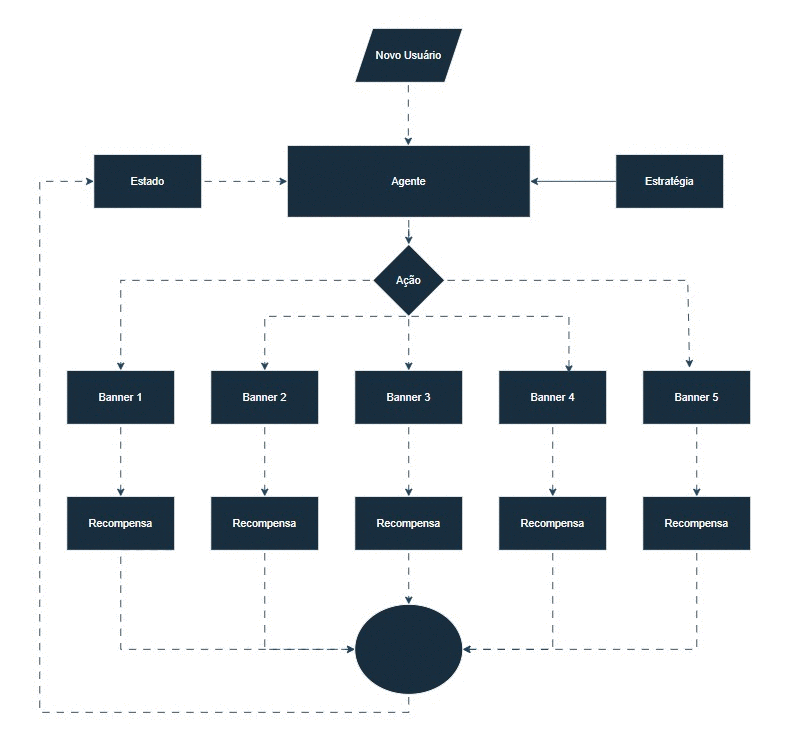

In [116]:
from IPython.display import Image, display
Image(filename="GIF_MaB.gif")

<br>

<br>

In [2]:
import numpy as np
import pandas as pd
from multi_armed_bandit import MaB
from arm import Arm
from bandit import Bandit
from strategy import EpsilonGreedyStrategy, GreedyStrategy, RandomStrategy, UCB


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def plot_total_reward_over_time(bandit_strategy,arms_rewards, arms):
    df = pd.DataFrame(data = arms_rewards, columns=arms)
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 5))
    
    plt.title(f'Estratégia {bandit_strategy}: Recompensas acumuladas', fontsize=16)
    plt.xlabel('Iteração', fontsize=14)
    plt.ylabel('Total Recompensas', fontsize=14)

    plt.tight_layout()
    colors = sns.color_palette("Set2", df.shape[1])

    sns.lineplot(data=df, palette = "Set2"  ,linestyle='-', linewidth=2);


In [5]:
def plot_share_arms_over_time(bandit_strategy,arms_rewards, arms):
    df = pd.DataFrame(data = arms_rewards, columns=arms)
    df_stack = df.divide(df.sum(axis=1), axis=0)
    colors = sns.color_palette("Set2", df.shape[1])
    ax = df_stack.plot(kind='area', figsize=(20,5),stacked=True, color=colors )

    ax.set_ylabel('Percent (%)')
    ax.margins(0, 0) # Set margins to avoid "whitespace"
    plt.title(f'Estratégia {bandit_strategy}: Representatividade', fontsize=16)
    plt.xlabel('Iteração', fontsize=14)
    plt.tight_layout()
    plt.show()


## A simulação

Vou simular a entrada de 12.000 usuários para entender o funcionamento de cada estratégia do Multi Armed Bandit, e assim, responder as seguintes questões:
- Qual estratégia gerou o maior número de vendas?
- Qual foi a diferença no número de vendas entre cada estratégia?



In [6]:
tamanho_do_teste = 12000

### Banners

Vamos criar os 5 banners do problema para a simulação. Para cada um, atribuir uma probabilidade de clique e a probabilidade de compra, **caso o clique tenha ocorrido.**

- **Banner 1**: 10% de chance de clique e 15% compra
- **Banner 2:** 25% de chance de clique e 8% compra
- **Banner 3:** 15% de chance de clique e 10% compra
- **Banner 4:** 20% de chance de clique e 6% compra
- **Banner 5:** 13% de chance de clique e 12% compra

In [117]:
def create_arms(mab):
    mab.create_arm(name="banner_1", click_prob=0.1, purchase_prob=0.15)
    mab.create_arm(name="banner_2", click_prob=0.25, purchase_prob=0.08)
    mab.create_arm(name="banner_3", click_prob=0.15, purchase_prob=0.1)
    mab.create_arm(name="banner_4", click_prob=0.2, purchase_prob=0.06)
    mab.create_arm(name="banner_5", click_prob=0.13, purchase_prob=0.12)

### Recompensas

Cada banner irá receber 1 ponto de recompensa caso o usuário se interesse em clicar e 3 pontos em caso compra.

<br>

## Comportamento de cada estratégia:

O objetivo aqui é entender a como cada estratégia irá distribuir os 12.000 usuários ao longo do teste.

### Estratégia: Random

In [8]:
random = RandomStrategy()
mab_random = MaB(random)
create_arms(mab_random)

In [9]:
total_purchase = []
for epoch in range(50):
    mab_random.play(tamanho_do_teste)
    total_purchase.append(mab_random.get_total_purchase())
    mab_random.reset_arms()

In [10]:
random_50epochs = total_purchase

In [11]:
mab_random.play(tamanho_do_teste)

In [12]:
random_rewards = mab_random.reward_history
random_purchases = mab_random.purchase_history

In [13]:
random_cumulative_sum = np.sum(random_rewards,axis=1)
random_cumulative_purchases = np.sum(random_purchases,axis=1)

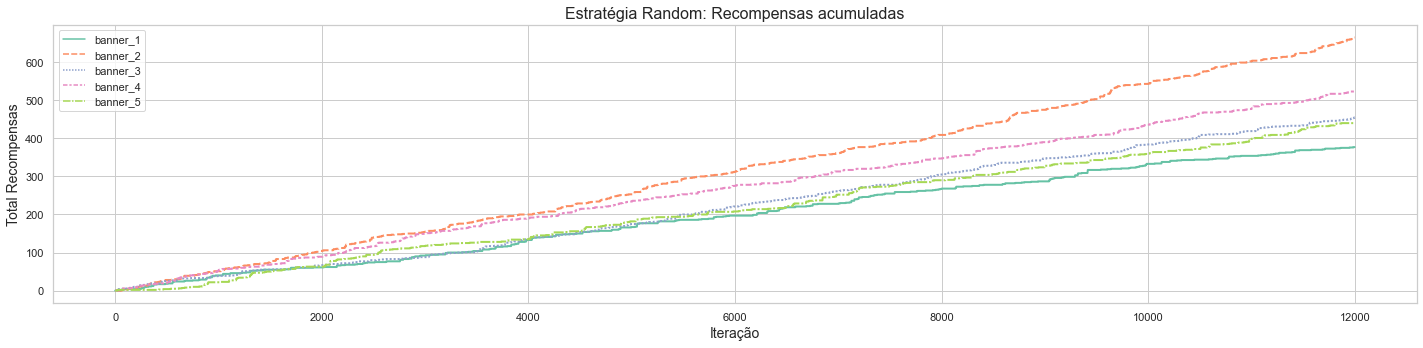

In [14]:
plot_total_reward_over_time("Random" ,random_rewards,mab_random.arms)

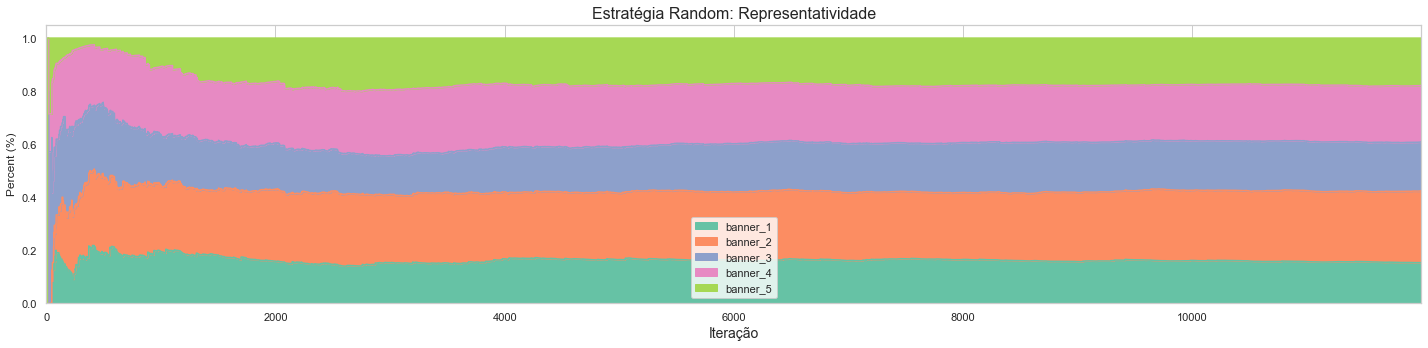

In [15]:
plot_share_arms_over_time("Random" ,random_rewards,mab_random.arms)

**Comentários:** Conforme esperado, a estratégia Random ao longo das iterações seleciona os banners de forma aleatória, o que torna a distribuição uniforme. Podemos ver também que o Banner 2 tem uma melhor performance, recebendo uma maior quantidade de recompensas ao logo da simulação.

<br>

### Estratégia: Greedy

In [16]:
greedy = GreedyStrategy()
mab_greedy = MaB(greedy)
create_arms(mab_greedy)

In [17]:
total_purchase = []
for epoch in range(50):
    mab_greedy.play(tamanho_do_teste)
    total_purchase.append(mab_greedy.get_total_purchase())
    mab_greedy.reset_arms()

In [18]:
greedy_50epochs = total_purchase

In [19]:
mab_greedy.play(tamanho_do_teste)

In [20]:
greedy_rewards = mab_greedy.reward_history
greedy_purchases = mab_greedy.purchase_history

In [21]:
greedy_cumulative_sum = np.sum(greedy_rewards,axis=1)
greedy_cumulative_purchases = np.sum(greedy_purchases,axis=1)

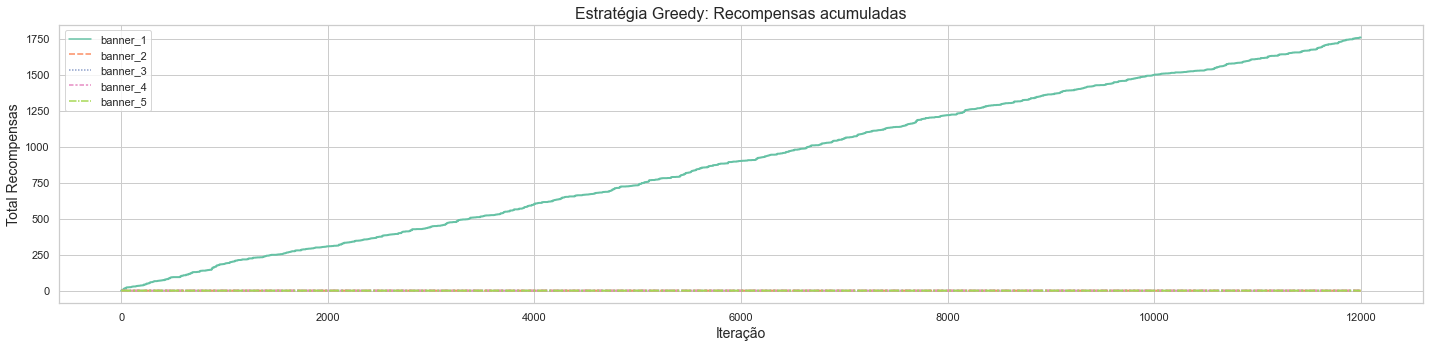

In [22]:
plot_total_reward_over_time("Greedy" ,greedy_rewards,mab_greedy.arms)

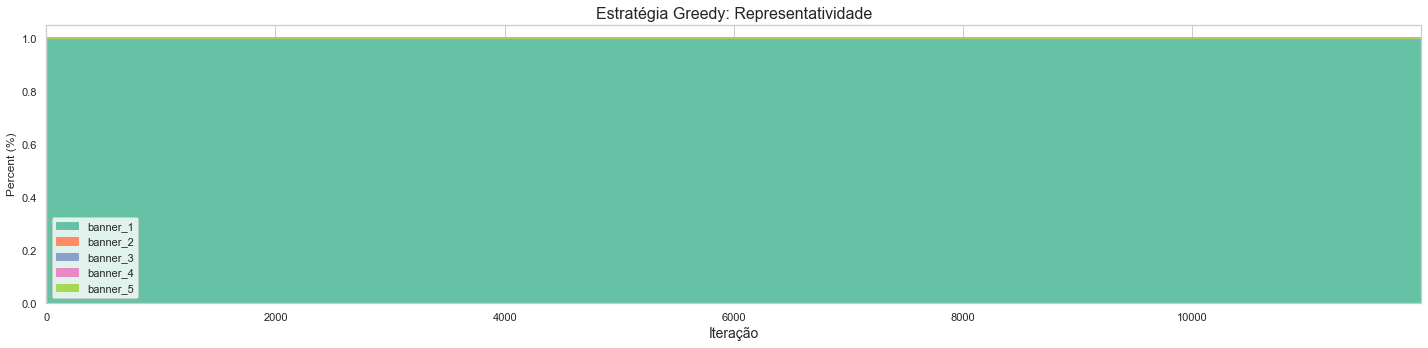

In [23]:
plot_share_arms_over_time("Greedy" ,greedy_rewards,mab_greedy.arms)

**Comentários:** A estratégia Greedy, como podemos ver, escolheu de forma equivocada o Banner 1 como o melhor banner. O fato dessa estratégia não possuir ações de Explore, faz com que ele não mude sua decisão com o tempo.

<br>

### Estratégia: E-Greedy (e = 10%)

In [76]:
egreedy = EpsilonGreedyStrategy(epsilon=0.1)
mab_egreedy = MaB(egreedy)
create_arms(mab_egreedy)

In [77]:
total_purchase = []
for epoch in range(50):
    mab_egreedy.play(tamanho_do_teste)
    total_purchase.append(mab_egreedy.get_total_purchase())
    mab_egreedy.reset_arms()

In [78]:
egreedy_50epochs = total_purchase

In [79]:
mab_egreedy.play(tamanho_do_teste)

In [80]:
egreedy_rewards = mab_egreedy.reward_history
egreedy_purchases = mab_egreedy.purchase_history

In [81]:
egreedy_cumulative_sum = np.sum(egreedy_rewards,axis=1)
egreedy_cumulative_purchases = np.sum(egreedy_purchases,axis=1)

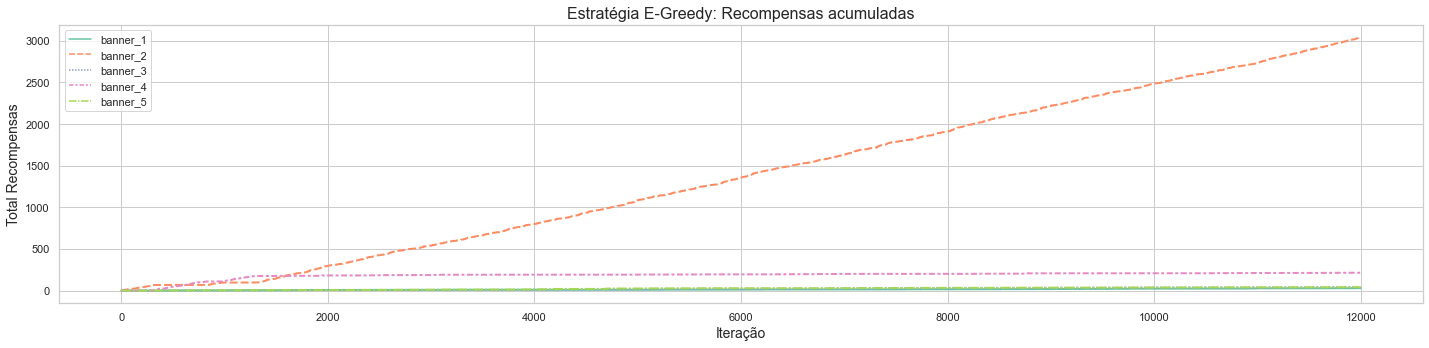

In [82]:
plot_total_reward_over_time("E-Greedy" ,egreedy_rewards,mab_egreedy.arms)

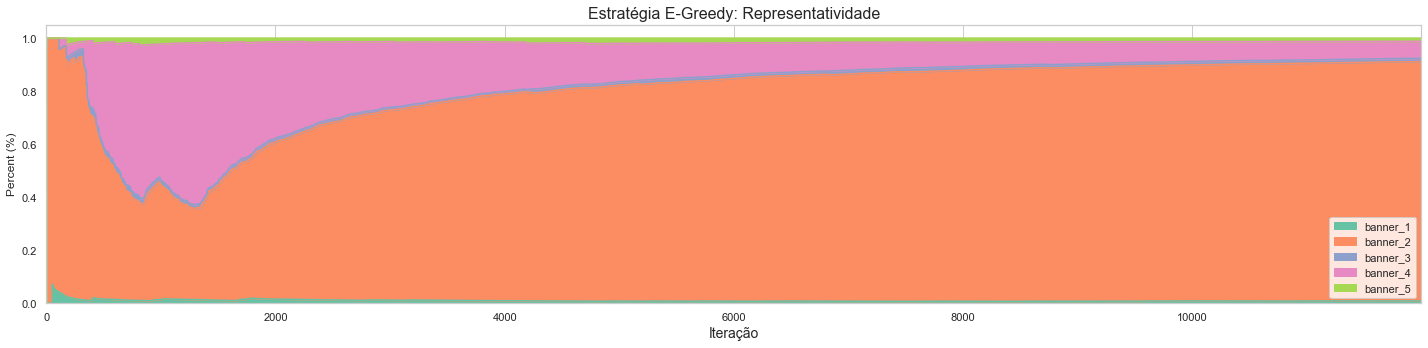

In [83]:
plot_share_arms_over_time("E-Greedy" ,egreedy_rewards,mab_egreedy.arms)

**Comentários:** Aqui tivemos uma variação interessante, o Banner 2 ganhou espaço logo no início, mas acabou perdendo representatividade antes das 2000 iterações. Mas devido as ações de explore fixadas em 10%, o Banner 2 voltou voltou a ganhar espaço com o tempo.

<br>

### Estratégia: UCB

In [84]:
upper_bound = UCB()
mab_ucb = MaB(upper_bound)
create_arms(mab_ucb)

In [85]:
total_purchase = []
for epoch in range(50):
    mab_ucb.play(tamanho_do_teste)
    total_purchase.append(mab_ucb.get_total_purchase())
    mab_ucb.reset_arms()

In [86]:
ucb_50epochs = total_purchase

In [87]:
mab_ucb.play(tamanho_do_teste)

In [88]:
ucb_rewards = mab_ucb.reward_history
ucb_purchases = mab_ucb.purchase_history

In [89]:
ucb_cumulative_sum = np.sum(ucb_rewards,axis=1)
ucb_cumulative_purchases = np.sum(ucb_purchases,axis=1)

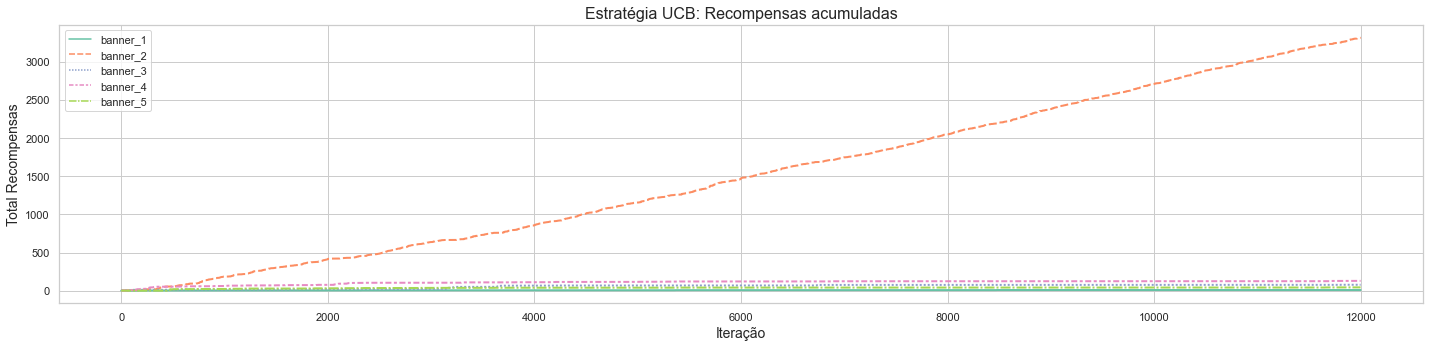

In [90]:
plot_total_reward_over_time("UCB" ,ucb_rewards,mab_ucb.arms)

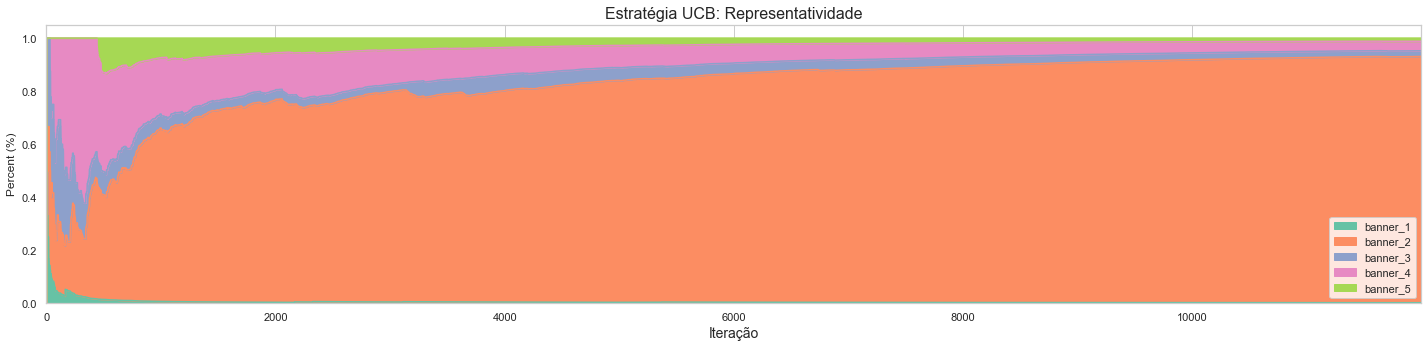

In [91]:
plot_share_arms_over_time("UCB" ,ucb_rewards,mab_ucb.arms)

**Comentários:** A estratégia UCB, iniciou a simulação escolhendo praticamente de forma aleatória, mas com o tempo o Banner 2 foi tomando o espaço dos outros com pior performance. Deu pra notar que essa estratégia atua com mais cautela e demora um pouco mais para escolher a melhor opção. Mas no fim o melhor banner tende a ganhar maior representatividade.

<br>

In [104]:
def get_percentage_diff(previous, current):
    try:
        percentage = (previous - current)/max(previous, current)
    except ZeroDivisionError:
        percentage = float('inf')
    return round(percentage,2)


In [105]:
def color_negative_red(val):
    color = 'red' if val < 0 else 'darkblue'
    return f'color: {color}'

In [106]:
def create_pct_diff_matrix(df):
    matrix = pd.DataFrame(df,index = df.index, columns = df.index)
    for column in df.index:
        for column_y in df.index:
            current = df[column].max()
            previous = df[column_y].max()
            matrix[column].loc[column_y] = get_percentage_diff(previous, current)
            
    ## sort by the best
    matrix['total'] = matrix.sum(axis=1)
    matrix = matrix.sort_values(by='total' ,ascending=False)
    matrix = matrix.drop(columns = 'total')
    
    matrix = matrix.style.applymap(color_negative_red).format('{:.2%}')
    
    return matrix


## Comparativo das Estratégias:

### Quantidade de compras geradas

<br>

In [102]:
df = pd.DataFrame({"UCB": ucb_cumulative_purchases,
                   "e-Greedy": egreedy_cumulative_purchases,
                   "Greedy": greedy_cumulative_purchases,
                   "Random": random_cumulative_purchases})


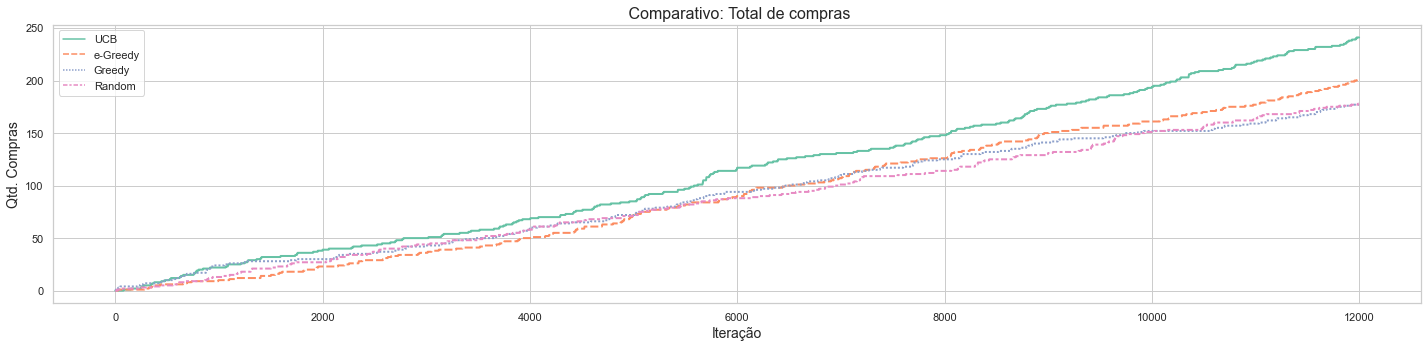

In [113]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 5))

plt.title(f' Comparativo: Total de compras', fontsize=16)
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('Qtd. Compras', fontsize=14)

# Plot the line using Seaborn
sns.lineplot(data=df, palette="Set2", linestyle='-', linewidth=2)

# Show the legend
plt.legend()

plt.tight_layout()
plt.show()


**Comentários:** Como é possível observar ao longo as 12.000 iterações, a estratégia UCB gerou mais compras do que as outras Estratégia, seguido pela e-Greedy. A tendência é este resultado se manter, dado que a e-Greedy tem 10% das ações fixadas em 10% e a UCB tende a diminuir as ações de Explore com o tempo.

<br>

In [107]:
total_purchase_by_strategy = df.iloc[-1].copy()

In [108]:
percent_diff_by_strategy = create_pct_diff_matrix(total_purchase_by_strategy)
percent_diff_by_strategy

,UCB,e-Greedy,Greedy,Random
UCB,0.00%,17.00%,27.00%,26.00%
e-Greedy,-17.00%,0.00%,12.00%,11.00%
Random,-26.00%,-11.00%,1.00%,0.00%
Greedy,-27.00%,-12.00%,0.00%,-1.00%


**Comentários:** Essa tabela mostra a diferença em percentual da quantidade de compras geradas por cada estratégia. Para entendermos mais claramente a diferença dos resultados de cada estratégia

<br>

### E se repetirmos o teste várias vezes? Como fica?

Ao longo do desenvolvimento dessa simulação, percebi que os resultados variavam um pouco a cada vez que executava o teste. Vamos repetir ele 50 vezes e ver como cada estratégia se sai.

In [109]:
df_50_epochs = pd.DataFrame({"UCB": ucb_50epochs,
                   "EGreedy": egreedy_50epochs,
                   "Greedy": greedy_50epochs,
                   "Random": random_50epochs})

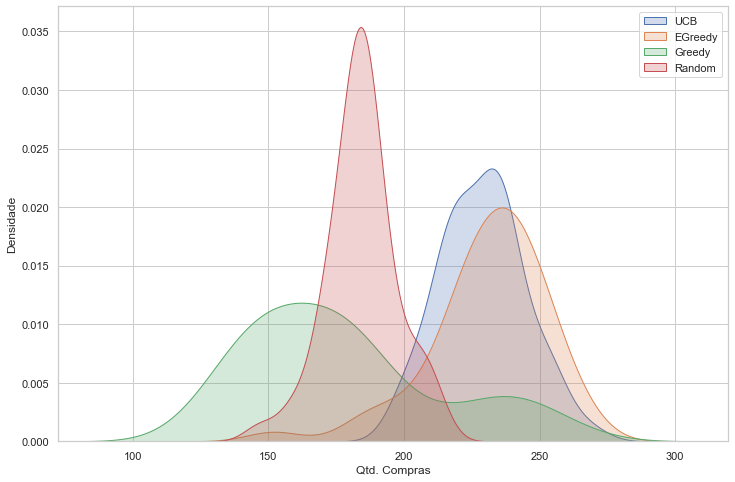

In [110]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plot density charts for each column
plt.figure(figsize=(12, 8))
for column in df_50_epochs.columns:
    sns.kdeplot(data=df_50_epochs[column], label=column, shade=True)

plt.xlabel('Qtd. Compras')
plt.ylabel('Densidade')
plt.legend()

plt.show()


**Comentários:** Podemos ver algumas informações interessantes: 
- As estratégias **UCB** e **e-Greedy** tem o desempenho bem parecido para este teste, gerando por volta de 240 compras em cada teste de 12.000 iterações. UCB com uma variância significativamente menor.<br>
- A estratégia **Random** possui uma menor variância em seus resultados, mas fica pra trás em termos de conversão das estratégias citadas anteriormente. <br>
- A estratégia **Greedy** possui a maior variância entre todas as anteriores, por vezes pode gerar bons resultados, se tiver a "sorte" do melhor Banner ser escolhido. Mas tende a perder para as outras estratégias com o volume de testes realizados. 

## Conclusão

O Multi Armed Bandit é uma tecnica poderosa e que pode ajudar bastante no dia-a-dia da empresa, pois as decisões são tomadas automaticamente de acordo com os resultados de cada variável do teste, trazendo velocidade na tomada de decisão comparado aos Testes A/B, por exemplo, que a decisão só é tomada após o fim do teste.<br>

Alguns pontos sobre cada estratégia:
- **UCB**: Ela tende a demorar um pouco mais para decidir qual é a melhor variável, logo tende a ter melhor performance em testes de média ou longa duração. 
- **e-Greedy**: Decide mais rápido qual é a melhor variável, mas corre um risco maior de se equivocar. Por isso tende a variar mais os resultados. Por terr essa característica, pode ser uma boa opção em testes mais curtos.
- **Random**: O Random vai permitir você escolher o melhor banner posteriormente. Como um teste A/B. Pela simplicidade, a escolha por um teste A/B seria mais indicado do que usar essa estratégia.
- **Greedy**: Aqui é como se a empresa não fizesse testes, escolhe uma opção logo no início e segue com ela até o fim sem testar outras opções. Pode acertar algumas vezes, mas tende a ser a pior opção que foi citada aqui.

Para estas variáveis, a estratégia UCB acabou levando a melhor, o que não quer dizer que sempre será a melhor opção. Vale também dizer que existem outras estratégias que não foram mencionadas aqui, as possibilidades são infinitas.

# Referências

[Multi-Armed Bandits: Como fazer boas escolhas](https://medium.com/data-hackers/multi-armed-bandits-como-fazer-boas-escolhas-e73a8422b71d) <br>
[Multi-armed bandit optimization makes testing faster and smarter with machine learning](https://frosmo.com/multi-armed-bandit-optimization-makes-testing-faster-and-smarter-with-machine-learning/) <br>
[Multi-Armed Bandits: Part 1](https://towardsdatascience.com/multi-armed-bandits-part-1-b8d33ab80697)<br>
[Multi-armed Bandits: uma alternativa para testes A/B](https://medium.com/itau-data/multi-armed-bandits-uma-alternativa-para-testes-a-b-d5db47d24006)